# LMB Python DNN Course Part 3





The first commands in this notebook perform some initial set-up and module imports, as we did in Part 1. 

In [3]:
%matplotlib inline
import os
import numpy as np  # Load the NumPy module, assign it the name "np" for convienence
from matplotlib import pyplot as plt
from matplotlib import colormaps

os.environ['KERAS_BACKEND'] = 'torch'
plt.rcParams["figure.figsize"] = (16,8) # Set plot size

from keras import models, layers, regularizers
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.optimizers import Adam
from course_util import plot_training_history

We will also use the same function from Part 1 to plot the history of the DNN training, i.e. to report the loss and accuracy, for both training and test data, during the training iterations.

## Predicting ptotein transmembrane spans

We now turn to our second example dataset which relates to biological sequences. The objective here will be to train a DNN to predict the location and extent of a protein's transmembrane span(s), if it has any.  

For this we will use an existing, published dataset that is provided by the paper that goes with the [TMHMM](https://www.ncbi.nlm.nih.gov/pubmed/11152613) transmembrane prediction program. As the name suggests this method used a hidden markov model (HMM) to learn and perform predictions. We hope to do better using a DNN.

In some sense, the TM spans of proteins are relatively easy features to predict from protein sequence alone because the TM span sits in a hydrophobic lipid bilayer and so the amino acids will tend to be substantially hydrophobic in nature. However, the situation is not so straightforward when charged residues are present in the TM span (can be a false negative), when aqueous globular domains have long internal hydrophobic helices (can be false positive), when multi-span TM proteins have small internal helicesm, and when the protein possesses a hydrophobic signalling peptide (e.g. to gain entry to the secretory system), which then is cleaved from the final protein.

<img src="images_ML/tm_prot.png" style="float:left;width:200px;">

The input to our DNNs will be amino acid sequences, albeit in an encoded form. And the output will be a prediction of 'membrane' or 'non-membrane' categories. Just like the original TMHMM program we will also further separate the non-membrane residues into an internal/cytoplasmic class and an external/lumenal/exoplamic class, and thus also give a prediction of the protein's membrane spanning topology.

### Training data

The training and test data will come from files that were provided when the TMHMM program was published. This has saved a lot of effort for using this as a tutorial dataset and we can trust that it is well curated. 

Because the training and test data are coming from bespoke formatted text files we first construct a function that can read the data into the NumPy arrays that we want to work with. The format of the file for each protein entry looks like the below example, i.e. with a protein amino acid sequence and corresponding codes to indicate whether a residue is inside `i`, membraneous `M`, or outside`o`:

In [4]:
with open('set160.labels') as file_obj:
    for i in range(4):
        print(file_obj.readline().strip())

>FTSH_ECOLI
MAKNLILWLVIAVVLMSVFQSFGPSESNGRKVDYSTFLQEVNNDQVREARINGREINVTKKDSNRYTTYIPVQDPKLLDNLLTKNVKVVGEPPEEPSLLASIFISWFPMLLLIGVWIFFMRQMQGGGGKGAMSFGKSKARMLTEDQIKTTFADVAGCDEAKEEVAELVEYLREPSRFQKLGGKIPKGVLMVGPPGTGKTLLAKAIAGEAKVPFFTISGSDFVEMFVGVGASRVRDMFEQAKKAAPCIIFIDEIDAVGRQRGAGLGGGHDEREQTLNQMLVEMDGFEGNEGIIVIAATNRPDVLDPALLRPGRFDRQVVVGLPDVRGREQILKVHMRRVPLAPDIDAAIIARGTPGFSGADLANLVNEAALFAARGNKRVVSMVEFEKAKDKIMMGAERRSMVMTEAQKESTAYHEAGHAIIGRLVPEHDPVHKVTIIPRGRALGVTFFLPEGDAISASRQKLESQISTLYGGRLAEEIIYGPEHVSTGASNDIKVATNLARNMVTQWGFSEKLGPLLYAEEEGEVFLGRSVAKAKHMSDETARIIDQEVKALIERNYNRARQLLTDNMDILHAMKDALMKYETIDAPQIDDLMARRDVRPPAGWEEPGASNNSGDNGSPKAPRPVDEPRTPNPGNTMSEQLGDK
# iiiiMMMMMMMMMMMMMMMMMMMMoooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooooMMMMMMMMMMMMMMMMMMMMMMMMMiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiiii

The function to read these data is a little fiddly, but a Python function that does this is provided below. 
A second training set was release with a later version of the TMHMM method; this has 243 proteins in it compared to the original 160. We will consider both in this tutorial.

### Variable size input

One of the innate problems when dealing with many types of biological sequence is that the lengths of the sequences can vary. This is an issue for neural networks that operate with a fixed size of inputs.

The way that we will deal with this here is to consider a sliding window, which will be of a fixed size. In other words we will only be looking at part of the protein sequence at one time. For the purposes of predicting TM spans this approach will work as long as the window is wide enough. 

We will be predicting the inside `"i"`, outside `"o"` or membrane `"M"` category of the window's central residue(s), and so the extent of the window provides a sequence context either side of the middle. Naturally this context needs to be large enough to provide sufficient information for the prediction. For example if the window were only a few residues then this would not see the whole of a TM span and there would be no way to distinguish between small hydrophobic segments in non-membrane situations. We find that more than 50 residues works fairly well, as this is wide enough to cover a large TM span and a few residues either side; included some non-membrane residues is important for assessing the inside/outside topology; the topology flips either side of the TM span.

When using a sliding window the edges of the protein sequence are potentially a problem; we need to extend the window over the edge of the protein sequence so the middle residue (in the window) can be one of the ofrst or last amino acids. We will fox this issue by extending the sequence with padding (`'-'` characters) so that the window cannot fall of the edges. Accompanying this we introduce a new data label (also `'-'`), which in effect is a class for empty, edge space. This presents little problem for the DNN and indeed having an edge context with its own special label can be helpful if the rules differ near the N- and C-terminii. 

<img src="images_ML/TM_DNN_window.png" style="float:left;">

We will be taking a short cut with this example as the DNNs input for non-membrane residues will be the non-membrane parts of the membrane proteins, rather than fully aqueous proteins. Choosing the later would be a better option in reality, although you have to be careful to have a degree of balance between positive (TM) and negative (no TM) training data.

### Data augmentation

The practice of using a sliding sequence window means that each protein will be used many times as different input; i.e. with different offsets. We  could have looked at only sequence regions that are centred on each TM span. However, given that the number of TM protein examples is fairly small this would be somewhat limiting. Using a sliding window so that each sequence is used many times is effectively a technique called *data augmentation*; the same input is used many times with different offests or transformations (for image data the generally means scaling and rotation). Each different view of the data will present a different, albeit relates, context and effectively increases the amount of training data.

## Loading training and test data

The below function reads the TM data file and converts the 1-letter codes for the amino acid sequence and the transmembrane category into Python integer numbers. This is done with a sliding window of specified size (via `win_size`) such that there will be several offset inputs fpr each protein. The `is_main` variable determines if the protein, with all its sliding-window sub-sequences, goes into the main training data or else the test data. The `test_frac` determines what proportion of the data is used as test. Note that this is only an approximate fraction as the function will not split a protein between test and training; overlapping sub-sequences are highly correlated and would introduce bias in the training set. 


In [5]:
from random import random, seed

CLASSES = 'ioM-'
AA = 'ACDEFGHIKLMNPQRSTVWY-'
AA_IDX = dict([(x,i) for i,x in enumerate(AA)])
LABEL_IDX  = dict([(x,i) for i,x in enumerate(CLASSES)])
NAA = len(AA)

def load_tm_data(file_path, win_size=25, pred_width=1,
                 stride=1, test_frac=0.1):

  half_width = int(win_size/2)
  pred_start = int(pred_width/2)
  pred_end = pred_width-pred_start

  train_data = []
  test_data = []
  train_labels = []
  test_labels = []
  
  prot_data = {}
    
  pad = CLASSES[-1] * half_width 
  with open(file_path) as file_obj:
    name = file_obj.readline().strip()[1:]
    
    while name:
      is_main = len(test_data) > (test_frac * len(train_data))
    
      seq = file_obj.readline()[2:-1]
      labels = file_obj.readline()[2:-1]
      null = file_obj.readline()

      n = len(seq)
      prot_data[name] = (seq, labels, is_main)     

      seq = pad + seq + pad
      labels = pad + labels + pad
        
      for i in range(half_width, n+half_width, stride):
        sub_seq = seq[i-half_width:i+half_width+1]
        sub_seq = [AA_IDX[aa] for aa in sub_seq]
        label = [labels[j] for j in range(i-pred_start,i+pred_end)] 
        label = [LABEL_IDX[j] for j in label]
        
        if is_main:
          train_data.append(sub_seq)
          train_labels.append(label)
        else:
          test_data.append(sub_seq)
          test_labels.append(label)

      name = file_obj.readline().strip()[1:]
 
  train_data = np.array(train_data)
  test_data = np.array(test_data)
  train_labels = np.array(train_labels)
  test_labels = np.array(test_labels)
  
  msg = 'Counts: training {:,}, test {:,} - Total proteins: {:,}'
  print(msg.format(len(train_labels), len(test_labels), len(prot_data)))
  
  return (train_data, train_labels), (test_data, test_labels), prot_data

### Properly separating the test data

When we split the test data from the main training data we must be very careful that the datasets are truly separate. For example we may want to guarantee that the members of an homologous protein family are always in the same segment. With our sliding window approach we can investigate the effect of not separating the data properly by spreading different sliding windows for the same proteins across both test and training data. We could achieve this simply by shuffling the data loaded from file so that it no longer separated into different protein origins.

### Preparing training data

We will start with a sliding window/region size of 20 residues. This will work to some degree, but we can easily investigate what happens with smaller or larger windows. With smaller regions we naturally get less sequence context, but training will be easier, as the input is smaller. Also, we will start with predicting only one, middle residue in our region and use the smaller of the TMHMM data files.

In [6]:
win_size = 20
train, test, prot_data = load_tm_data('set160.labels', win_size) # set243.labels or set160.labels

Counts: training 57,346, test 5,768 - Total proteins: 160


The output from the data reading function is then split into input and output sections for both the main training data and the test data.

If we display the shapes of the resulting input data arrays we can see that the size of the last axis corresponds to the size of the sliding window. Within this the different amino acids (plus edge/gap) will be encoded, at least initially, as numbers 0-20. At this stage the outputs are simple, single categorical numbers 0-3 (for `'i'`, `'o'`, `'M'` or `'-'`).

In [7]:
train_data, train_labels = train
test_data, test_labels = test

print(train_data.shape)
print(train_labels.shape)
print(train_data[0])
print(train_labels[0])

(57346, 21)
(57346, 1)
[20 20 20 20 20 20 20 20 20 20 10  8 14  9  9 17  9  1  2  1  9]
[1]


The output, categorical labels will be converted into a binary (one-hot) encoding; a 1.0 in a particular column sets the category and other values are 0.0.

In [8]:
train_labels = to_categorical(train_labels, num_classes=4)
test_labels = to_categorical(test_labels, num_classes=4)
print(train_labels.shape)
print(train_labels[0])

(57346, 4)
[0. 1. 0. 0.]


Next we perform a similar procedure to prepare the input data, i.e. converting it to categorical binary matrices and then flattening into vectors. Here we explicitly state the number of categorical classes (`NAA`) because there is a small chance that a protein won't contain all the different types of amino acid.

In [9]:
train_data = to_categorical(train_data, num_classes=NAA)
test_data = to_categorical(test_data, num_classes=NAA)

print(train_data.shape)
print(test_data.shape)

(57346, 21, 21)
(5768, 21, 21)


Because each data item is effectively a matrix, we flatten the last two axes into a single vector, as the DNN expects. The size of this vector is the inital matrix width time height.

In [10]:
n, a, b = train_data.shape
m, a, b = test_data.shape

train_data = train_data.reshape(n, a*b)
test_data = test_data.reshape(m, a*b)

print(train_data.shape)
print(test_data.shape)

(57346, 441)
(5768, 441)


To make the loading of datasets easier later on. The above preparation for the input and output data is placed in a handy function called `prepare_data()`, which runs `load_tm_data()` internally and then performs the required categorical transformations etc. We can then run this function again when we switch to a different data file or change window size etc. 

This function also has some extra features which will be useful when trying more complex DNNs. Specifically there is: reshaping of the output labels in the section after `if train_labels.ndim > 2:`, for when we move from predicting just a single residues class to predicting classes for several residues; and an option to avoid converting the input data to a one-hot encoding (using `to_cat=False`) when we move to a learned encoding in the DNN itself.

At the end of the function we send back the prepared input and outputs for the main training and test data, the sizes of the input and output vectors as we will need this when we construct the DNNs and finally sequence information relating to each protein; so that we can easily go back to the original sequences

In [11]:
def prepare_data(data_file, win_size=10, pred_width=1, stride=1, test_frac=0.1, to_cat=True):
  
  test, train, prot_data = load_tm_data(data_file, win_size, pred_width, stride, test_frac)
  train_data, train_labels = test
  test_data, test_labels = train

  train_labels = to_categorical(train_labels, num_classes=len(CLASSES))
  test_labels = to_categorical(test_labels, num_classes=len(CLASSES))

  if False: # train_labels.ndim > 2:
    n, a, b = train_labels.shape
    m, a, b = test_labels.shape # Last two axes are the same size
    out_size = a * b

    train_labels = train_labels.reshape(n, out_size) # Flatten last two axes
    test_labels = test_labels.reshape(m, out_size)
  else:
    out_size = list(train_labels.shape[1:])
  
  if to_cat:
    train_data = to_categorical(train_data, num_classes=len(AA))
    test_data = to_categorical(test_data, num_classes=len(AA))
    n, a, b = train_data.shape
    #m, a, b = test_data.shape
    #in_size = a * b
    #train_data = train_data.reshape(n, in_size)
    #test_data = test_data.reshape(m, in_size)
    
    in_size = [a,b]
    
  else:
    in_size = train_data.shape[-1]
  
  return (train_data, train_labels), (test_data, test_labels), in_size, out_size, prot_data

We will re-load the training and test data to check this function.

In [12]:
win_size = 40
train, test, in_size, out_size, prot_data = prepare_data('set160.labels', win_size)
(train_data, train_labels) = train
(test_data, test_labels) = test
print(f'In size:{in_size}, Out size:{out_size}')

Counts: training 57,346, test 5,768 - Total proteins: 160
In size:[41, 21], Out size:[4]


Our initial (fully connected) DNN architecture follows the same lines that were used at the end of the numeral recogntition example presented earlier. The neural network model is a sequential one with a number of `Dense` and `Dropout` layers, where the width of each layer diminishes toward the output. However, we use a `for` loop to avoid repetitive code.
We set the last layer to (somewhat arbitrarily) be double the size of the output, so that it is definitely larger than the output vector, given the later will be changing in size as we tweak things.

In [13]:
nn1 = models.Sequential()
nn1.add(layers.Input(in_size))
nn1.add(layers.Flatten())
nn1.add(layers.Dense(128, activation='gelu'))
nn1.add(layers.Dense(32, activation='gelu'))


The last layer is set to be the same size as the output vectors and then the DNN is finalised. Note that the loss function and paired last-layer activation function are appropriate for categorical selection where only one out[ut value can be true.

In [14]:
nn1.add(layers.Dense(out_size[0], activation='softmax'))
nn1.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',])
nn1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 861)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       110,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,596 (447.64 KB)

 Trainable params: 114,596 (447.64 KB)

 Non-trainable params: 0 (0.00 B)

Training is initially for 10 iteractions (`epoch=`), updating the DNN with batches of 512 training samples.

In [15]:
history1 = nn1.fit(train_data, train_labels, epochs=10, batch_size=64,
                  validation_data=(test_data, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5498 - loss: 1.0060 - val_accuracy: 0.7238 - val_loss: 0.6142
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7257 - loss: 0.6054 - val_accuracy: 0.7399 - val_loss: 0.5831
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7433 - loss: 0.5737 - val_accuracy: 0.7419 - val_loss: 0.5837
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7483 - loss: 0.5648 - val_accuracy: 0.7413 - val_loss: 0.5765
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7506 - loss: 0.5595 - val_accuracy: 0.7431 - val_loss: 0.5784
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7578 - loss: 0.5484 - val_accuracy: 0.7438 - val_loss: 0.5768
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7639 - loss: 0.5385 - val_accuracy: 0.7542 - val_loss: 0.5719
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7683 - loss: 0.5331 - val_accuracy: 0.

The history of the loss and accuracy are plotted, as before, with our helper function `plot_training_history()`. We can see that predictor works  to an accuracy of about 75%. Note that this is the *per-residue* accuracy for the TM class assignment; even if some residues are incorrectly assigned the overall presence of a TM span will be more accurate. 

Unfortunately this network is subject to a notable amount of over-training; the loss and accuracy improve for the training data but not the test data. This is not unexpected, given that there are twenty different possible amino acids for each sequence position and so the number of total possible sequences is vast, and yet we have only sequenced a tiny fraction of this in the training data. In essence, long protein sequences are sparsely represented and thus potentially difficult to generalise.

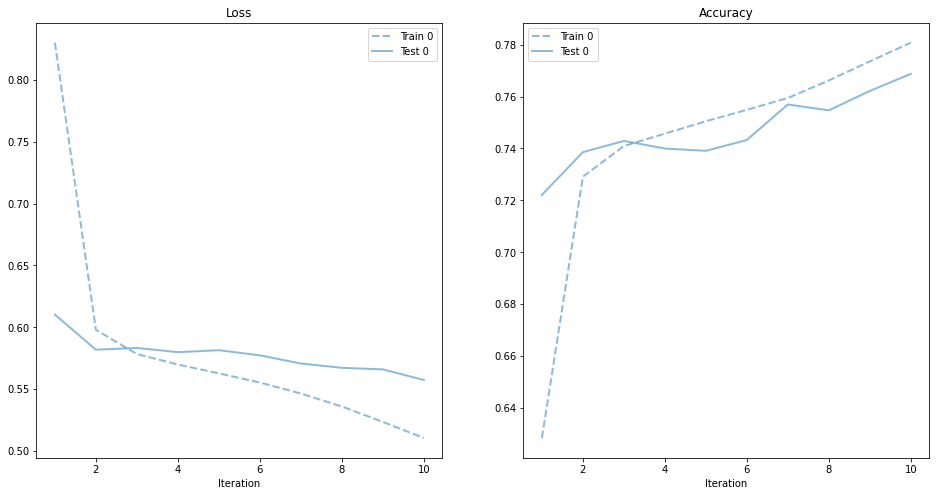

In [189]:
plot_training_history(history1)

To visualise the predictive output categories some more helper functions are provided: given a DNN model and a sequence `get_seq_scores()` will get the predicted scores for each output category using a sliding window and `plot_seq_predict()` will display this as graphs. Note that the neural network model object `nn` is input and the `.predict()` function is used after each sub-sequence has been correctly converted to the same vector form used in the training. This function plots the scores for the four possibilities (inside, outside, membrane or sequence edge) as line graphs along the length of a test protein sequence.

In [286]:
def get_seq_scores(nn, seq, win_size, in_size, pred_size=1, categorical=True):
  n = len(seq)
  hw = int(win_size/2)
  w = hw + hw + 1
  pad = '-' * hw
  pseq = pad + seq + pad
  scores = np.zeros((n, 4))
  pidx = [AA_IDX[aa] for aa in pseq]
    
  for i in range(n):
    query = pidx[i:i+w]
        
    if categorical:
      query = to_categorical(query, num_classes=NAA)
    
    out = nn.predict(np.array([query]), verbose=0)
    if out.ndim > 2:
      scores[i] = out[0,hw+1]
    else:
      scores[i] = out    
  
  
  print(333, out.shape)
    
  return scores

def plot_seq_predict(nn, seq, win_size, in_size, pred_size=1, categorical=True):
  scores = get_seq_scores(nn, seq, win_size, in_size, pred_size, categorical)

  opts = {'alpha':0.4, 'linewidth':3}
  i, o, m, x = scores.T

  fig, ax = plt.subplots()
  fig.set_size_inches(16.0, 3.0)  

  ax.plot(i, color='#B0B040', label='Inside', **opts)
  ax.plot(o, color='#4080FF', label='Outside', **opts)
  ax.plot(m, color='#B00000', label='Membrane', **opts)
  ax.plot(x, color='#808080', label='Edge', linestyle='--', **opts)
  ax.set_xlabel('Sequence position')
  ax.legend()
  plt.show()

The sequence predictions can now be run on any one-letter amino acid sequence.

In [287]:
seq1 = "MYGKIIFVLLLSEIVSISASSTTGVAMHTSTSSSVTKSYISSQTNDTHKRDTYAATPRAHEVSEISVRTVYPPEEETGERVQLAHHFSEPEITLIIFGVMAGVIGTILLISYGIRRLIKKSPSDVKPLPSPDTDVPLSSVEIENPETSDQ"
seq2 = 'MWSTRSPNSTAWPLSLEPDPGMASASTTMHTTTIAEPDPGMSGWPDGRMETSTPTIMDIVVIAGVIAAVAIVLVSLLFVMLRYMYRHKGTYHTNEAKGTEFAESADAALQGDPALQDAGDSSRKEYFI'
print(win_size, in_size)
plot_seq_predict(nn1, seq1, win_size, in_size)
plot_seq_predict(nn1, seq2, win_size, in_size)

255 255


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_25" is incompatible with the layer: expected axis -1 of input shape to have value 861, but received input with shape (1, 5355)[0m

Arguments received by Sequential.call():
  • inputs=torch.Tensor(shape=torch.Size([1, 255, 21]), dtype=float32)
  • training=False
  • mask=None
  • kwargs=<class 'inspect._empty'>

Next we can investigate what happens if we change the widths of the full-connected layers and the number of layers. As you night expect, smaller networks suffer less from overtraining but having a network that is too shallow and/or narrow will reduce test accuracy. Conversely larger networks tend to over-train, get slow and may show no benefit to test accuracy.

## <font color=purple>Exercise 1: Tweaking layers</font>

<font color=purple>See if it is possible to optimise the widths and number of `Dense` layers to improve the DNN test data loss and accuracy.
</font>

In [18]:
# Exercise code

input_shape = [in_size]
nn2 = models.Sequential()
nn2.add(layers.Input(in_size))

# Insert more layers here....
    
nn2.add(layers.Dense(out_size[0], activation='softmax'))
nn2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',])

history2 = nn2.fit(train_data, train_labels, epochs=5, batch_size=512,
                  validation_data=(test_data, test_labels))

Train on 57346 samples, validate on 5768 samples
Epoch 1/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.9974 - accuracy: 0.5453 - val_loss: 0.8294 - val_accuracy: 0.6559
Epoch 2/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.7734 - accuracy: 0.6760 - val_loss: 0.7180 - val_accuracy: 0.7061
Epoch 3/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.6998 - accuracy: 0.7074 - val_loss: 0.6692 - val_accuracy: 0.7240
Epoch 4/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.6632 - accuracy: 0.7190 - val_loss: 0.6414 - val_accuracy: 0.7290
Epoch 5/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.6416 - accuracy: 0.7245 - val_loss: 0.6244 - val_accuracy: 0.7302
Epoch 6/10
57346/57346 [==============================] - 0s 3us/step - loss: 0.6278 - accuracy: 0.7281 - val_loss: 0.6144 - val_accuracy: 0.7353
Epoch 7/10
57346/57346 [==============================] - 0s 3us/step - los

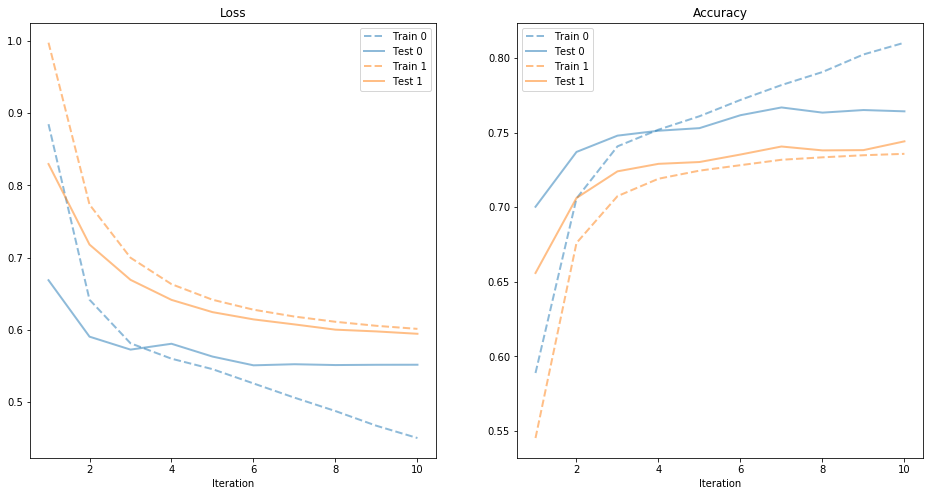

In [19]:
plot_training_history(history1, history2)

### Input indow size

As well as the DNN parameters we can naturally also optimise the way in which the sequence is used as input.  For example here we train and test the network on input with a somewat larger window size:

In [69]:
win_size = 75
train, test, in_size, out_size, prot_data = prepare_data('set160.labels', win_size)
(train_data, train_labels) = train
(test_data, test_labels) = test

Counts: training 57,346, test 5,768 - Total proteins: 160


In [153]:
nn3 = models.Sequential()
nn3.add(layers.Input(in_size))
nn3.add(layers.Flatten())

nn3.add(layers.Dense(128, activation='gelu')) 
nn3.add(layers.Dense(32, activation='gelu')) 
    
nn3.add(layers.Dense(out_size[0], activation='softmax'))
nn3.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',])

history3 = nn3.fit(train_data, train_labels, epochs=10, batch_size=64,
                   validation_data=(test_data, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5310 - loss: 1.0230 - val_accuracy: 0.7209 - val_loss: 0.6067
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7277 - loss: 0.5993 - val_accuracy: 0.7408 - val_loss: 0.5843
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7399 - loss: 0.5762 - val_accuracy: 0.7498 - val_loss: 0.5761
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7501 - loss: 0.5639 - val_accuracy: 0.7498 - val_loss: 0.5765
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7523 - loss: 0.5566 - val_accuracy: 0.7474 - val_loss: 0.5693
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7572 - loss: 0.5460 - val_accuracy: 0.7516 - val_loss: 0.5624
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7611 - loss: 0.5432 - val_accuracy: 0.7554 - val_loss: 0.5549
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7714 - loss: 0.5263 - val_accuracy: 0.

Increasing the window size can give some improvement in accuracy, but larger input naturally makes the data more sparse and thus easier to overtrain.

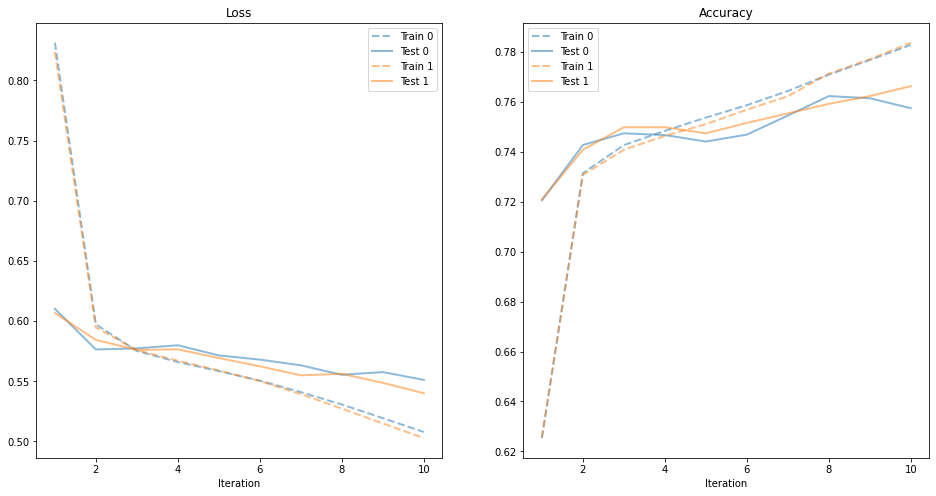

In [154]:
plot_training_history(history1, history3)

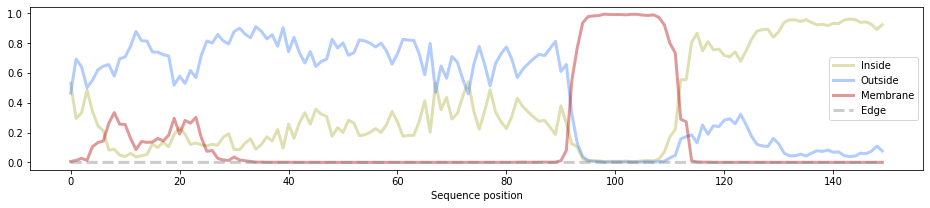

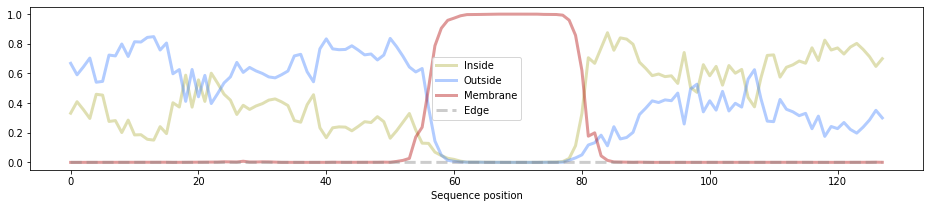

In [155]:
plot_seq_predict(nn3, seq1, win_size, in_size)
plot_seq_predict(nn3, seq2, win_size, in_size)

## Parameter searches

Rather then manually searching for optimised parameters, these can naturally be sought in an automated manner with programming. A simple, though time consiming, approach here is an exhaustive seach that re-runs the DNN training many times and records the performance for a range (or grid) of paramaters. 

In [156]:
accs = []
win_sizes = range(10, 100, 10)
for win_size in win_sizes:
    train, test, in_size, out_size, prot_data = prepare_data('set160.labels', win_size)
    (train_data, train_labels) = train
    (test_data, test_labels) = test
    
    nn = models.Sequential()    
    nn.add(layers.Input(in_size))
    nn.add(layers.Flatten())
    
    nn.add(layers.Dense(128, activation='gelu'))
    nn.add(layers.Dense(32, activation='gelu'))
    
    nn.add(layers.Dense(out_size[0], activation='softmax'))
    nn.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy',])

    h = nn.fit(train_data, train_labels, epochs=3, batch_size=512,
                validation_data=(test_data, test_labels))
    
    accs.append(h.history['val_accuracy'][-1])

Counts: training 57,346, test 5,768 - Total proteins: 160
Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3457 - loss: 1.3422 - val_accuracy: 0.4775 - val_loss: 1.1925
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4991 - loss: 1.1414 - val_accuracy: 0.4868 - val_loss: 1.0271
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5188 - loss: 0.9879 - val_accuracy: 0.5843 - val_loss: 0.9023
Counts: training 57,346, test 5,768 - Total proteins: 160
Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4404 - loss: 1.2828 - val_accuracy: 0.4879 - val_loss: 1.0709
Epoch 2/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5226 - loss: 1.0265 - val_accuracy: 0.6330 - val_loss: 0.8709
Epoch 3/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6302 - loss: 0.8475 - val_accuracy: 0.6810 - val_loss: 0.7309
Counts: training 57,346, test 5,768 - Total proteins: 160
Epoch 1/3
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0

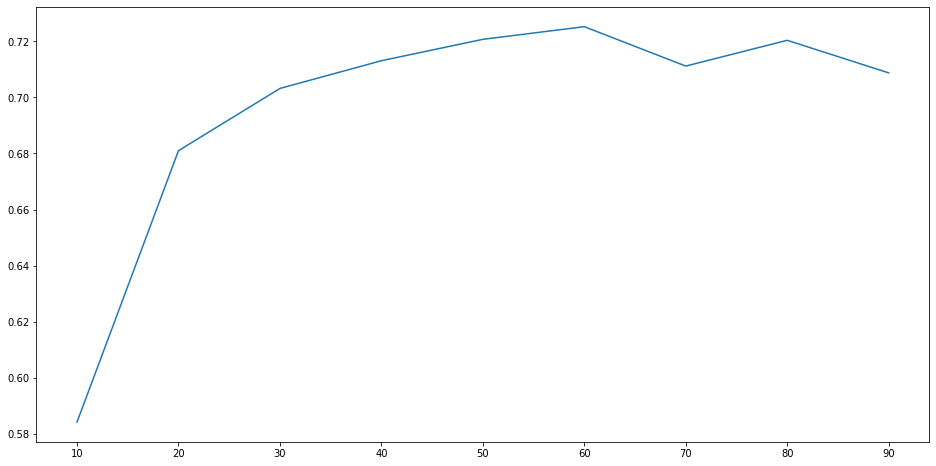

In [157]:
plt.plot(win_sizes, accs)
plt.show()

## Improving predictions by predicting more

When we inspect some of the TM category predictions for individual residue we can see that a common kind of error is a small segment (often only a single residue) that flips to the opposite inside/outside category compared to its neighbours. Naturally, this is not observed in the training class labels. Predicting the inside/outside class is more difficult that the membrane class, so mistakes are not surprising (generally this is base on something like the postive-inside rule near the TM span). This problem can be largely ameliorated by actually making more residue predictions. For example, rather than just predicting the i/o/M class for one central residue we can predict the class for several central residues. The DNN will learn that the categories are largely continuous and that transitions like 'iiooM' are never seen in the training data. In effect the adjacent residues give each other more context, albeit in the form of a predicted class.

In [214]:
win_size = 80
pred_width = 5
train, test, in_size, out_size, prot_data = prepare_data('set160.labels', win_size, pred_width)
(train_data, train_labels) = train
(test_data, test_labels) = test
print(f'In size:{in_size}, Out size:{out_size}')

Counts: training 57,346, test 5,768 - Total proteins: 160
In size:[81, 21], Out size:[5, 4]


Note that when we train a network for an output where multiple classifications can be true at once we should swith to the `binary_crossentropy` loss function and pair this with the `sigmoid` activation function.

In [215]:
a, b = out_size
nn4 = models.Sequential()
nn4.add(layers.Input(in_size))
nn4.add(layers.Flatten())
    
nn4.add(layers.Dense(256, activation='relu'))
nn4.add(layers.Dense(64, activation='relu'))

nn4.add(layers.Dense(a*b, activation='sigmoid'))
nn4.add(layers.Reshape([a, b]))
nn4.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy',])
nn4.summary()

Model: "sequential_136"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_121 (Flatten)           │ (None, 1701)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_374 (Dense)               │ (None, 256)            │       435,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_375 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_376 (Dense)               │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_34 (Reshape)            │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,460 (1.73 MB)

 Trainable params: 453,460 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [190]:
history4 = nn4.fit(train_data, train_labels, epochs=10, batch_size=64,
                   validation_data=(test_data, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.4620 - loss: 0.5001 - val_accuracy: 0.7125 - val_loss: 0.3002
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7441 - loss: 0.2818 - val_accuracy: 0.7434 - val_loss: 0.2777
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7701 - loss: 0.2561 - val_accuracy: 0.7492 - val_loss: 0.2703
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7820 - loss: 0.2441 - val_accuracy: 0.7568 - val_loss: 0.2700
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.7930 - loss: 0.2350 - val_accuracy: 0.7633 - val_loss: 0.2691
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8053 - loss: 0.2232 - val_accuracy: 0.7655 - val_loss: 0.2667
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8174 - loss: 0.2124 - val_accuracy: 0.7705 - val_loss: 0.2654
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8378 - loss: 0.1957 - val_accuracy: 0.

Hopefully you will see that predicting for multiple adjascent residues works really well with both better loss and accuracy.

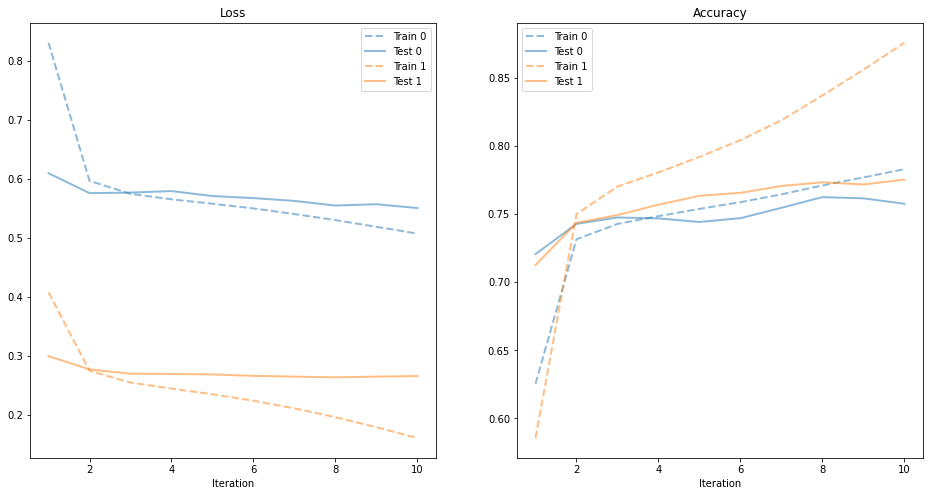

In [191]:
plot_training_history(history1, history4)

Visualising the score profiles along a couple of test sequences shows that the predictions are now smoother.

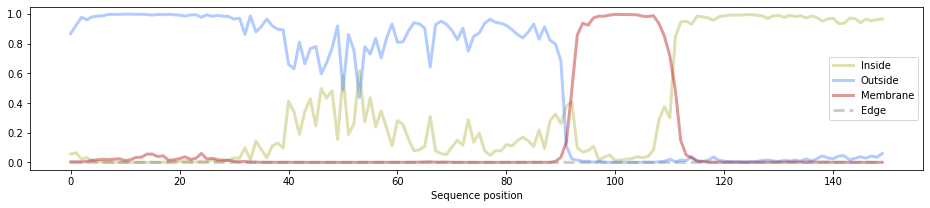

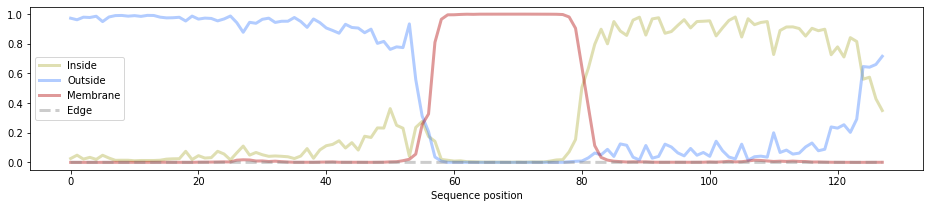

In [192]:
plot_seq_predict(nn4, seq1, win_size, in_size, pred_width)
plot_seq_predict(nn4, seq2, win_size, in_size, pred_width)

## <font color=purple>Exercise 2: Choosing the loss function</font>

<font color=purple>Test what happens to the performance of the DNN if you keep using the `categorical_crossentropy` loss function and the corresponding `softmax` activation function for the last layer, as we did initially when only predicting for one residue.
</font>

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.3462 - loss: 0.7710 - val_accuracy: 0.4750 - val_loss: 0.7221
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5056 - loss: 0.7040 - val_accuracy: 0.5668 - val_loss: 0.6679
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6029 - loss: 0.6541 - val_accuracy: 0.6637 - val_loss: 0.6259
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6891 - loss: 0.6142 - val_accuracy: 0.6925 - val_loss: 0.6000
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7192 - loss: 0.5915 - val_accuracy: 0.7096 - val_loss: 0.5859
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7379 - loss: 0.5774 - val_accuracy: 0.7283 - val_loss: 0.5778
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7519 - loss: 0.5693 - val_accuracy: 0.7333 - val_loss: 0.5729
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7590 - loss: 0.5640 - val_accuracy: 0.

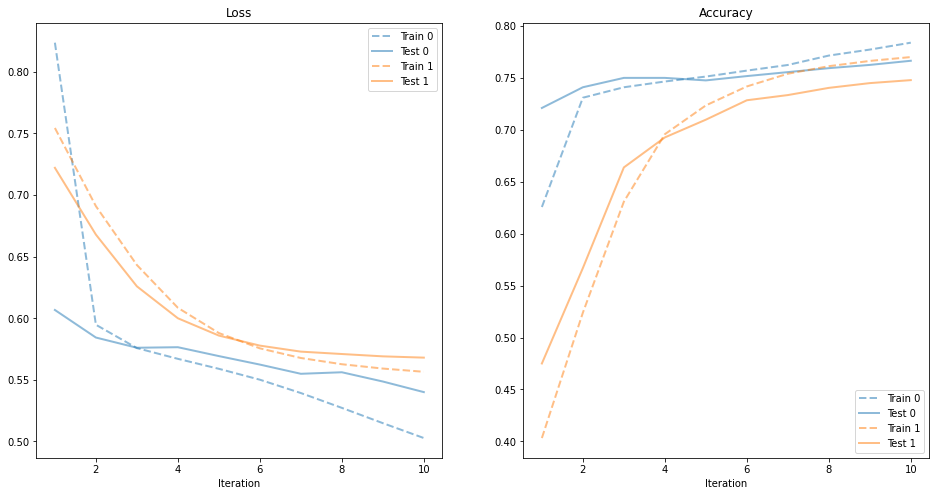

In [167]:
a, b = out_size
nn3b = models.Sequential()
nn3b.add(layers.Input(in_size))
nn3b.add(layers.Flatten())
    
nn3b.add(layers.Dense(128, activation='relu'))
nn3b.add(layers.Dense(32, activation='relu'))

###
nn3b.add(layers.Dense(a*b, activation='softmax'))
###
nn3b.add(layers.Reshape([a, b]))
####
nn3b.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy',])

# Fill in here

history3b = nn3b.fit(train_data, train_labels, epochs=10, batch_size=512,
                   validation_data=(test_data, test_labels))

plot_training_history(history3, history3b)

### Reducing over-training

We can employ the same regularisation and droput strategies as we used with the numeral recognition in Part 1 to try to minimise the overtraining, i.e. where the tes and training loss/accuracy diverge; indicating that the DNN has become too specialised on the training data and less general.

In [217]:
a, b = out_size
nn5 = models.Sequential()
reg = regularizers.l2(0.001)
    
nn5.add(layers.Input(in_size))
nn5.add(layers.Flatten())
    
nn5.add(layers.Dense(256, activation='relu', kernel_regularizer=reg))
nn5.add(layers.Dropout(0.2))
nn5.add(layers.Dense(64, activation='relu', kernel_regularizer=reg))
nn5.add(layers.Dropout(0.2))

nn5.add(layers.Dense(a*b, activation='sigmoid'))
nn5.add(layers.Reshape([a, b]))
    
nn5.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy',])
nn5.summary()

Model: "sequential_138"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_122 (Flatten)           │ (None, 1701)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_377 (Dense)               │ (None, 256)            │       435,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_378 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_379 (Dense)               │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_35 (Reshape)            │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 453,460 (1.73 MB)

 Trainable params: 453,460 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [218]:
history5 = nn5.fit(train_data, train_labels, epochs=10, batch_size=64,
                   validation_data=(test_data, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.4281 - loss: 0.9182 - val_accuracy: 0.6923 - val_loss: 0.4540
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7099 - loss: 0.4374 - val_accuracy: 0.7315 - val_loss: 0.3646
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7441 - loss: 0.3626 - val_accuracy: 0.7353 - val_loss: 0.3404
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7514 - loss: 0.3365 - val_accuracy: 0.7360 - val_loss: 0.3261
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7589 - loss: 0.3191 - val_accuracy: 0.7454 - val_loss: 0.3143
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7662 - loss: 0.3083 - val_accuracy: 0.7539 - val_loss: 0.3064
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7758 - loss: 0.2979 - val_accuracy: 0.7641 - val_loss: 0.3015
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7892 - loss: 0.2877 - val_accuracy: 0.

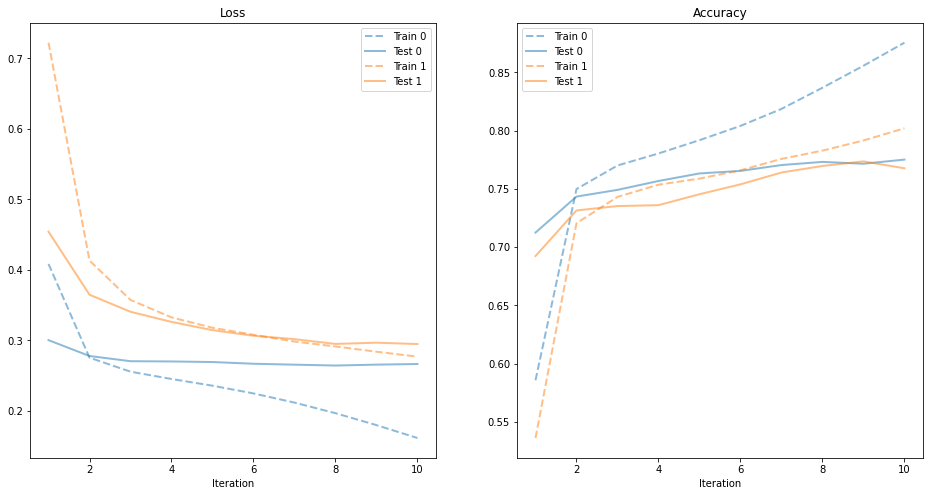

In [219]:
plot_training_history(history4, history5)

In [220]:
loss, acc = nn5.evaluate(train_data, train_labels)
msg = 'Train Loss: {:.3f} Acc: {:.2f}%'.format(loss, 100.0*acc)
print(msg)
loss, acc = nn5.evaluate(test_data, test_labels)
msg = 'Test Loss: {:.3f} Acc: {:.2f}%'.format(loss, 100.0*acc)
print(msg)

1793/1793 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8265 - loss: 0.2555
Train Loss: 0.257 Acc: 82.46%
181/181 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7223 - loss: 0.3207
Test Loss: 0.295 Acc: 76.77%


Lots of tweaking to this style of network doesn't give much improvement to the test accuracy. So next we move on to consider different types of network layer.

Because we have a problem with the sparseness of amino acid sequences and generalisation to other sequences, we will introduce a layer that provides an alternative to the (one-hot) binary categorical matrix we initially used as input. This is an `Embedding` layer. In essence, this provides a lower dimensionality encoding of the amino acid sequences compared to the twenty-dimensional binary encoding. It works with the original index-encoded (0-20) form of the amino acid codes (hence `train_data_idx` etc.) and converts this to a low-dimensional vector; four in this case.

A general encoding of the amino acids into a single, simple vector form doesn't work especially well. However, the Embedding layer will adopt a different encoding for each sequence position, which are learned (i.e. optimised) during the DNN training. The new layer is added before the Dense layers and its output must be flattened into a vector.

In [221]:
win_size = 80
pred_width = 5
train, test, in_size, out_size, prot_data = prepare_data('set160.labels', win_size, # or set243.labels
                                              pred_width, to_cat=False)
(train_data_idx, train_labels) = train
(test_data_idx, test_labels) = test

Counts: training 57,346, test 5,768 - Total proteins: 160


In [222]:
a, b = out_size
reg = regularizers.l2(0.0001)

nn6 = models.Sequential()
nn6.add(layers.Input([in_size]))
nn6.add(layers.Embedding(NAA, 4))
nn6.add(layers.Flatten()) # Make a 1D vector

nn6.add(layers.Dense(256, activation='relu', kernel_regularizer=reg))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(64, activation='relu', kernel_regularizer=reg))
nn6.add(layers.Dropout(0.2))
#nn6.add(layers.BatchNormalization())

nn6.add(layers.Dense(a*b, activation='sigmoid'))
nn6.add(layers.Reshape([a, b]))

nn6.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])
nn6.summary()

Model: "sequential_139"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 81, 4)          │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_123 (Flatten)           │ (None, 324)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_380 (Dense)               │ (None, 256)            │        83,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_381 (Dense)               │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_382 (Dense)               │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_36 (Reshape)            │ (None, 5, 4)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,032 (394.66 KB)

 Trainable params: 101,032 (394.66 KB)

 Non-trainable params: 0 (0.00 B)

In [223]:
history6 = nn6.fit(train_data_idx, train_labels, epochs=10, batch_size=64,
                   validation_data=(test_data_idx, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5610 - loss: 0.4393 - val_accuracy: 0.7346 - val_loss: 0.2811
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.7714 - loss: 0.2694 - val_accuracy: 0.7645 - val_loss: 0.2706
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.7952 - loss: 0.2502 - val_accuracy: 0.7901 - val_loss: 0.2520
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8141 - loss: 0.2337 - val_accuracy: 0.7946 - val_loss: 0.2467
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8217 - loss: 0.2263 - val_accuracy: 0.7885 - val_loss: 0.2472
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8300 - loss: 0.2197 - val_accuracy: 0.7906 - val_loss: 0.2463
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8386 - loss: 0.2147 - val_accuracy: 0.8006 - val_loss: 0.2506
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8455 - loss: 0.2077 - val_accuracy: 0.

As we can see by looking at the training history, this DNN performs better, especially with regards to the loss, and has even less over-trainaing. This can be attributed to the Embedding layer decreasing the number of trainable parameters; the vector is size 4, rather than size 21, before the Dense layer. Also, the 4D positional encoding of the different amino acids represents axes of general predictive characteristics that extends better to unseen sequence combinations. An analogous, though general, predictive characteristic is residue hydrophobicity.

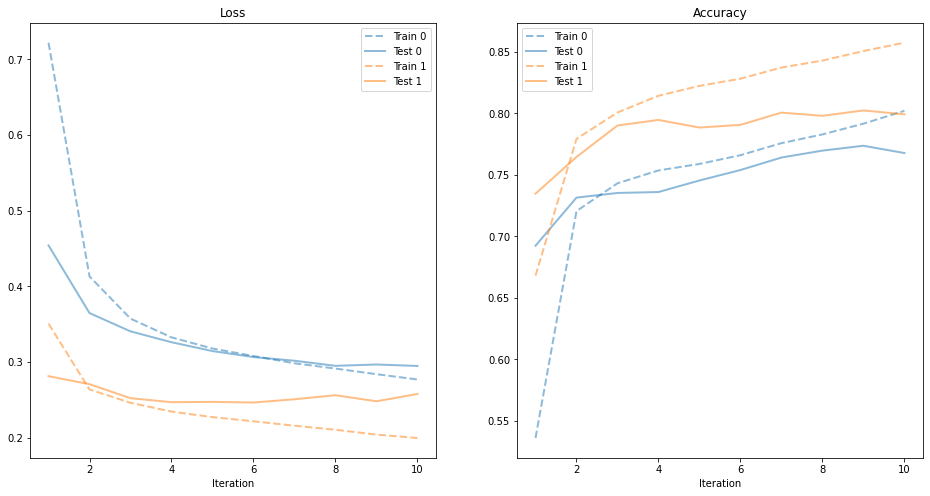

In [224]:
plot_training_history(history5, history6)

We can also see how this improvement changes the graph of test sequence scores. The indide and outside categories are not so distinct, but the scores along the sequence are perhaps smoother:

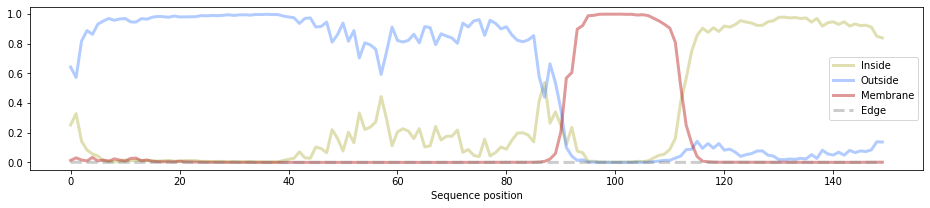

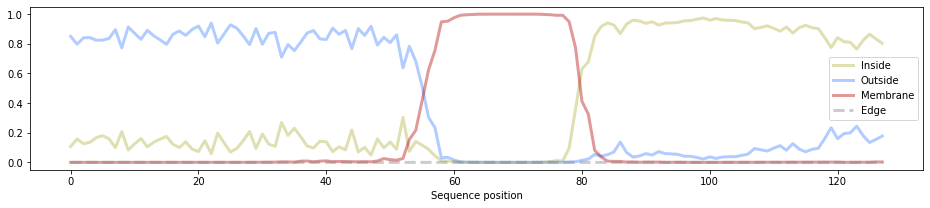

In [225]:
plot_seq_predict(nn6, seq1, win_size, in_size, pred_width, categorical=False)
plot_seq_predict(nn6, seq2, win_size, in_size, pred_width, categorical=False)

## <font color=purple>Exercise 3: Adding more data</font>

<font color=purple>Compare the above network (`nn6`) when run on the two different input data files 'set160.labels' and 'set243.labels' Visualise both training histories.
</font>

In [37]:
# Exercise code

## Examining errors

As should be common practice with training DNNs, we will investigate out data to see where the worst errors occur, to see if that gives us any clue about how to improve the training. Alternatively, we may find a problem with our training or test data, which might have mistakes... 

To help with this we first define a function `plot_seq_known` that simply plots the known categorical labels for a protein as a line graph that we can directly compare with the predictions, in a similar way to `plot_seq_predict()`.

In [226]:
# Get worst input sub_seq
def plot_seq_known(known, title):
  opts = {'alpha':0.4, 'linewidth':3}
  i, o, m, x = known.T

  fig, ax = plt.subplots()
  fig.set_size_inches(16.0, 3.0)  

  ax.set_title(title)
  ax.plot(i, color='#B0B040', label='Inside', **opts)
  ax.plot(o, color='#4080FF', label='Outside', **opts)
  ax.plot(m, color='#B00000', label='Membrane', **opts)
  ax.plot(x, color='#808080', label='Edge', linestyle='--', **opts)
  ax.set_xlabel('Sequence position')
  ax.legend()
  plt.show()

Next we loop through the protein data that we have bee storing in `prot_data`, which is output when we loaded the data files. This contains a dictionary, keyed by protein name, to record the proteins, sequence, known categorical labels and whether it was in the main training set (or test set).

We take proteins that are in the test set and compare the predicted scores from a DNN with the known labels (converted to a binary categorical encoding). The comparison involves simply calculating the distance between the output categorcal and known vector, then the iverall score for the protein is the average of this. Finally the proteins with the accompanying socres are sorted worst-first.

In [227]:

def sort_by_error(nn, prot_data, win_size, in_size, pred_width, categorical=False):
  seq_scores = []

  for prot_name in sorted(prot_data):
      seq, labels, is_main = prot_data[prot_name]
    
      if not is_main:
          scores = get_seq_scores(nn, seq, win_size, in_size, pred_width, categorical)
          known = to_categorical(np.array([LABEL_IDX[l] for l in labels]), num_classes=len(CLASSES))
          d2 = (scores - known)**2
          dist = d2.sum(axis=1) ** 0.5
          seq_score = dist.mean()
          seq_scores.append((seq_score, prot_name, seq, known))

  seq_scores.sort(reverse=True)
  scores, prot_names, seqs, knowns = zip(*seq_scores)
    
  return scores, prot_names, seqs, knowns

After collating the scores we can then inspect the test protein's prediction score and known categorical profiles (i.e. along the sequence) by using out helper functions. 

In [228]:
scores, prot_names, seqs, knowns = sort_by_error(nn6, prot_data, win_size, in_size, pred_width, categorical=False)
idx = 0
plot_seq_predict(nn6, seqs[idx], win_size, in_size, pred_width, categorical=False)
plot_seq_known(knowns[idx], prot_names[idx])

NameError: name 'nn7' is not defined

Lastly, we augment our DNN with another new type of layer: a `Conv1D`. As the name suggests, this is not a fully-connected layer. This is a convolutional layer; these feature heavily in the next course on images. The idea here is that the network tries to learn a number of fixed-width patterns (often called 'filters'). These patterns are short vectors that are applied to only a small patch of the input. Effectively this creates a local vocabulary of sub-structures within the training input. The notion is that the range of patterns is limited and so they become general, and match better on unseen data.

In [290]:
n_patterns = 11
w_pattern = 11
reg = regularizers.l2(0.0001)

nn7 = models.Sequential()
nn7.add(layers.Input([in_size]))
nn7.add(layers.Embedding(NAA, 4))
#nn7.add(layers.Dropout(0.1))

nn7.add(layers.Conv1D(n_patterns, w_pattern, activation='relu',))
nn7.add(layers.Flatten())

nn7.add(layers.Dense(256, activation='relu', kernel_regularizer=reg))
nn7.add(layers.Dropout(0.2))
nn7.add(layers.Dense(64, activation='relu', kernel_regularizer=reg))
nn7.add(layers.Dropout(0.2))
#nn6.add(layers.BatchNormalization())

nn7.add(layers.Dense(a*b, activation='sigmoid'))
nn7.add(layers.Reshape([a, b]))

nn7.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])
nn7.summary()

Model: "sequential_105"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_73 (Embedding)        │ (None, 255, 4)         │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_150 (Conv1D)             │ (None, 245, 11)        │           495 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_44 (Flatten)            │ (None, 2695)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 256)            │       690,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_199 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_200 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 84)             │         5,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_28 (Reshape)            │ (None, 21, 4)          │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 712,663 (2.72 MB)

 Trainable params: 712,663 (2.72 MB)

 Non-trainable params: 0 (0.00 B)

In [106]:
history7a = nn7.fit(train_data_idx, train_labels, epochs=10, batch_size=64,
                   validation_data=(test_data_idx, test_labels))

Epoch 1/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.5047 - loss: 0.4861 - val_accuracy: 0.7140 - val_loss: 0.3064
Epoch 2/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7374 - loss: 0.2961 - val_accuracy: 0.7362 - val_loss: 0.2772
Epoch 3/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7668 - loss: 0.2698 - val_accuracy: 0.7530 - val_loss: 0.2747
Epoch 4/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.7799 - loss: 0.2596 - val_accuracy: 0.7803 - val_loss: 0.2531
Epoch 5/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.7994 - loss: 0.2443 - val_accuracy: 0.7907 - val_loss: 0.2484
Epoch 6/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8136 - loss: 0.2331 - val_accuracy: 0.8083 - val_loss: 0.2353
Epoch 7/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8238 - loss: 0.2248 - val_accuracy: 0.8197 - val_loss: 0.2275
Epoch 8/10
897/897 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.8391 - loss: 0.2125 - val_accuracy: 0.

The training of this DNN takes more time than the others, but some improvement is visible.

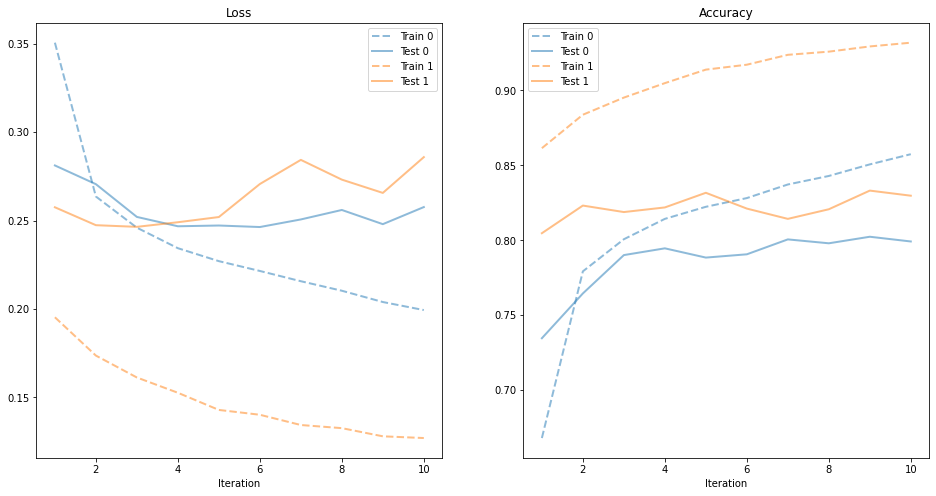

In [235]:
plot_training_history(history6, history7a)

Pleasingly, the predictions are generally smoother for adjascent residues.

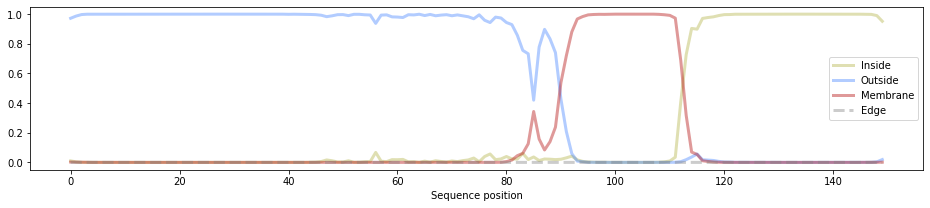

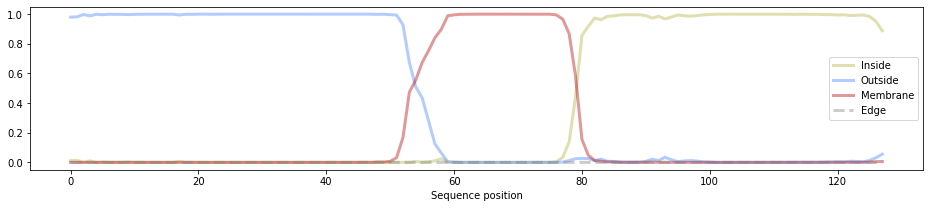

In [236]:
plot_seq_predict(nn7, seq1, win_size, in_size, pred_width, categorical=False)
plot_seq_predict(nn7, seq2, win_size, in_size, pred_width, categorical=False)

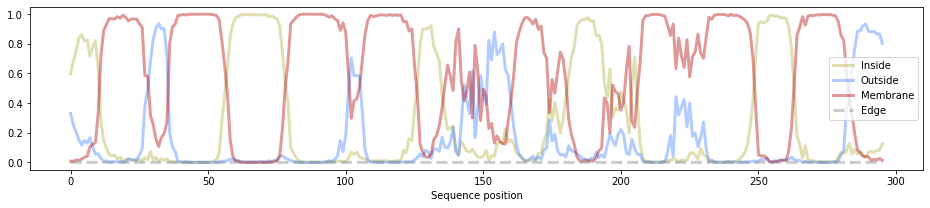

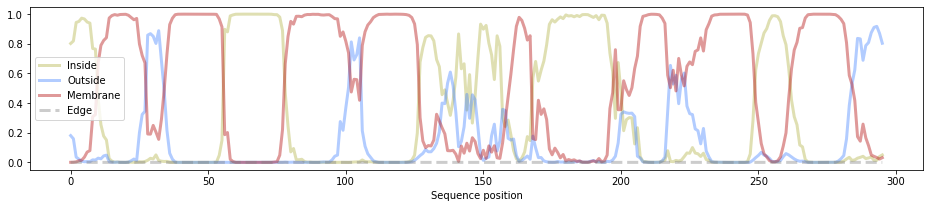

In [237]:
seq = prot_data['CYOE_ECOLI'][0] # '4F2_HUMAN', CYOE_ECOLI
plot_seq_predict(nn6, seq, win_size, in_size, pred_width, categorical=False)
plot_seq_predict(nn7, seq, win_size, in_size, pred_width, categorical=False)

In [405]:
win_size = 512
pred_width = 3
train, test, in_size, out_size, prot_data = prepare_data('set243.labels', win_size, # or set243.labels
                                              pred_width, to_cat=False)
(train_data_idx, train_labels) = train
(test_data_idx, test_labels) = test
print(in_size, out_size)

Counts: training 90,342, test 9,311 - Total proteins: 161
513 [3, 4]


In [ ]:
import keras_hub

a, b = out_size
#n_patterns = 11
#w_pattern = 11
#reg = regularizers.l2(0.0001)

nn8 = models.Sequential()
nn8.add(layers.Input([in_size]))
nn8.add(layers.Embedding(NAA, 8))
nn8.add(layers.GaussianNoise(0.1))

nn8.add(layers.Conv1D(16, 11, activation='gelu', strides=4, padding="same"))
nn8.add(layers.Dropout(0.1))
nn8.add(layers.Conv1D(32, 11, activation='gelu', strides=4, padding="same"))
nn8.add(layers.Dropout(0.1))
nn8.add(layers.Conv1D(64, 11, activation='gelu', strides=2, padding="same"))
nn8.add(layers.Dropout(0.1))
        
nn8.add(keras_hub.layers.TransformerEncoder(intermediate_dim=64, num_heads=4, dropout=0.1))
nn8.add(keras_hub.layers.TransformerEncoder(intermediate_dim=64, num_heads=4, dropout=0.1))

nn8.add(layers.Conv1D(8, 1, activation='gelu',))
nn8.add(layers.Flatten())
nn8.add(layers.Dense(a*b, activation='sigmoid'))
nn8.add(layers.Reshape([a, b]))

nn8.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy',])
nn8.summary()

In [ ]:
utils.plot_model(nn8)

In [ ]:
history8 = nn8.fit(train_data_idx, train_labels, epochs=20, batch_size=64,
                   validation_data=(test_data_idx, test_labels))

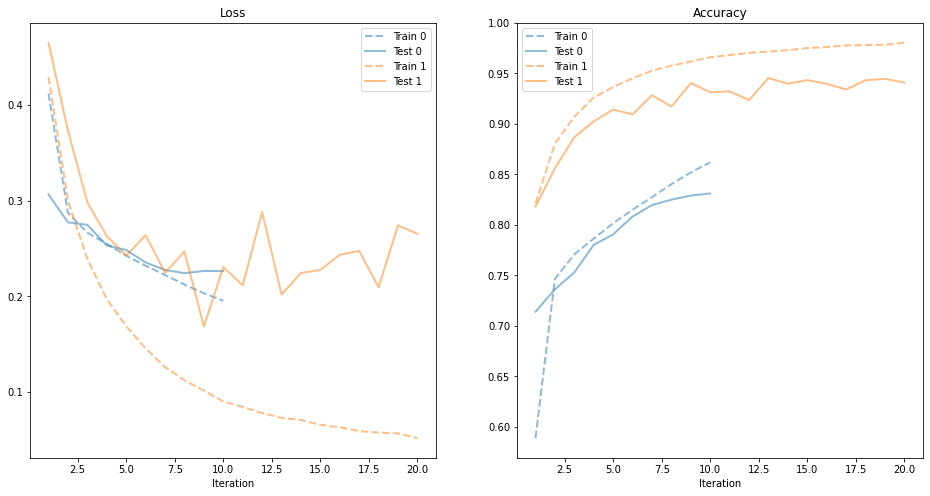

In [406]:
plot_training_history(history7a, history8)

333 (1, 4)


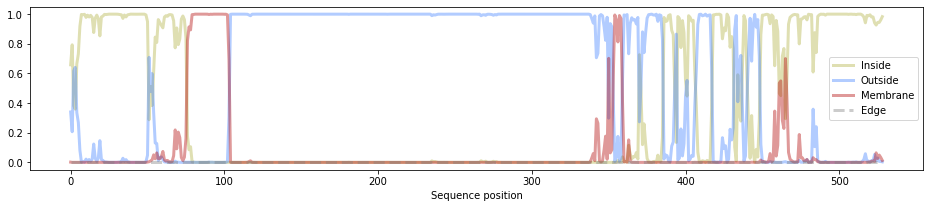

333 (1, 4)


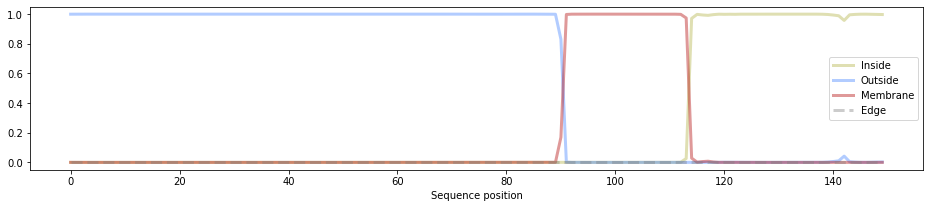

333 (1, 4)


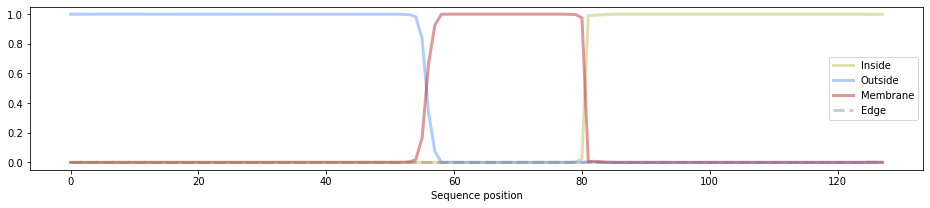

333 (1, 4)


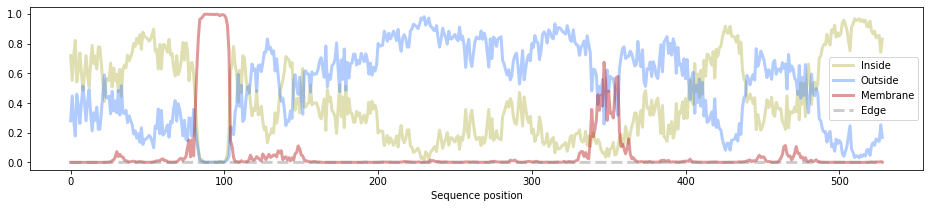

333 (1, 4)


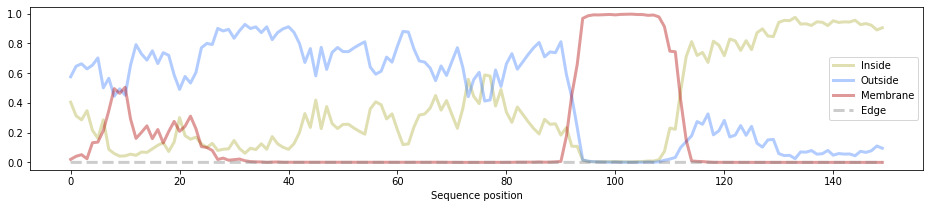

333 (1, 4)


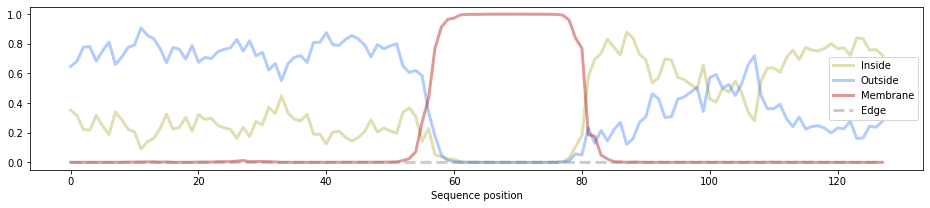

In [404]:
seq = prot_data['4F2_HUMAN'][0] # '4F2_HUMAN', CYOE_ECOLI
#plot_seq_predict(nn7, seq, win_size, in_size, pred_width, categorical=False)
plot_seq_predict(nn8, seq,  win_size, in_size, 1, categorical=False)
plot_seq_predict(nn8, seq1, win_size, in_size, 1, categorical=False)
plot_seq_predict(nn8, seq2, win_size, in_size, 1, categorical=False)
plot_seq_predict(nn1, seq,  41, [41,21], 1)
plot_seq_predict(nn1, seq1, 41, [41,21], 1)
plot_seq_predict(nn1, seq2, 41, [41,21], 1)

## <font color=purple>Exercise 4: Getting above 95%</font>

<font color=purple>Try to tweak the above DNN to get a test accuracy of >95% within 20 iterations. You can adjust the window sizes, output prediction with and internal DNN parameters.
</font>

In [61]:
# Exercise code

win_size = 200 # Fill in here
pred_width = 3 #  Fill in here

train, test, in_size, out_size, prot_data = prepare_data('set243.labels', win_size,
                                              pred_width, to_cat=False)
(train_data_idx, train_labels) = train
(test_data_idx, test_labels) = test

n_patterns = 7 # Maybe adjust 
w_pattern = 7 # Maybe adjust 
reg = regularizers.l2(0.0001) # Maybe adjust 

nn8 = models.Sequential()
nn8.add(layers.Embedding(NAA, 4, input_length=in_size)) # Maybe adjust from 4D

nn8.add(layers.Conv1D(n_patterns, w_pattern, dilation_rate=4, activation='relu',))
nn8.add(layers.Flatten())

for width in [out_size*8, out_size*2]: # Maybe adjust 
    nn8.add(layers.Dense(width, activation='relu', kernel_regularizer=reg))
    nn8.add(layers.Dropout(0.2))

nn8.add(layers.Dense(out_size, activation='sigmoid'))
nn8.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy',])

history8 = nn8.fit(train_data_idx, train_labels, epochs=20, batch_size=512,
                   validation_data=(test_data_idx, test_labels))

plot_training_history(history7a, history8)

Counts: training 90,342, test 9,311 - Total proteins: 161
Train on 90342 samples, validate on 9311 samples
Epoch 1/20
90342/90342 [==============================] - 3s 29us/step - loss: 0.4809 - accuracy: 0.7644 - val_loss: 0.3826 - val_accuracy: 0.8162
Epoch 2/20
90342/90342 [==============================] - 2s 25us/step - loss: 0.3173 - accuracy: 0.8574 - val_loss: 0.2824 - val_accuracy: 0.8663
Epoch 3/20
90342/90342 [==============================] - 2s 25us/step - loss: 0.2532 - accuracy: 0.8918 - val_loss: 0.2637 - val_accuracy: 0.8797
Epoch 4/20
90342/90342 [==============================] - 2s 25us/step - loss: 0.2265 - accuracy: 0.9077 - val_loss: 0.2568 - val_accuracy: 0.8925
Epoch 5/20
90342/90342 [==============================] - 2s 25us/step - loss: 0.2045 - accuracy: 0.9216 - val_loss: 0.2353 - val_accuracy: 0.9004
Epoch 6/20
90342/90342 [==============================] - 2s 25us/step - loss: 0.1893 - accuracy: 0.9298 - val_loss: 0.2299 - val_accuracy: 0.9050
Epoch 7/20


KeyboardInterrupt: 

## Going further...

That's the end of this course. However, there are a few ways that we might like to take this prediction in the future. Firstly, we can make much better use of fully aqueous proteins (i.e. no TM span), which could be used for fully 'inside' or fully 'ouside' sequence examples and serve as negative training examples. Secondly, we could expand the number of protein sequenxces by using close homologues, though here we would have to carefully balance the sizes of the protein families, and make sure they dont spread across the test/train split. Thirdly, we could predict leading signal peptides (e.g. for entry into the secretory system) and any cleavage site at the same time, which would hopfully remove a source of false positive errors.